<a href="https://colab.research.google.com/github/mykolesiko/eeg_investigation/blob/master/emotions_RACNN_dataleak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import random
import math
import time
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import numpy as np
from  scipy import stats
import scipy
np.random.seed(1)
torch.manual_seed(1)
random.seed(1)

Сетка по статье https://drive.google.com/file/d/1ia3W9vgdZLurEx4R7ndVL05clQLEarKF/view?usp=sharing . Оставлена только первая сверточная часть temporal_feature_extractor

In [4]:
import os
os.chdir("/content/drive/MyDrive/MADE/Project/deap")

In [5]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [6]:
class Args:
  def __init__(self): #(data_path, epoch, batch_siz, image_size, learning_rate, weight_deca, learning_rate, learning_rate_gamma, weight_bce, load, output_dir)
    self.data_path = "/content/drive/MyDrive/MADE/semester2/CV/contest02/data/"
    self.epochs = 2
    self.batch_size = 1000
    self.lr= 3e-4
    self.weight_decay= 1e-6
    self.learning_rate=None
    self.learning_rate_gamma=None
    self.weight_bce=1
    self.load=None
    self.output_dir="/content/drive/MyDrive/MADE/Project/RACNN_models/"
    self.data_dir ="./data_preprocessed_python/"# "/content/drive/MyDrive/MADE/Project/train/physionet.org/"
args = Args()   

In [7]:
def get_padding(in_size, kernel_size, stride):
    if (in_size % stride == 0):
        padding = max(kernel_size - stride, 0)
    else:
        padding = max(kernel_size - (in_size % stride), 0)
    return (padding)    

In [8]:
def get_temporal_feature_extractor(input_size, batch_norm):
  pad = get_padding(input_size, 5,  2)
  conv1 = nn.Conv3d(1, 32, kernel_size = (1, 1, 5), stride=(1, 1, 2), padding=(0, 0, 2))
  bn1 = nn.BatchNorm3d(32)
  relu1 = nn.ReLU()
  pad = get_padding(input_size, 3,  2)
  conv2 = nn.Conv3d(32, 32, kernel_size = (1, 1, 3), stride=(1, 1, 2), padding=(0, 0, pad))
  bn2 = nn.BatchNorm3d(32)
  relu2 = nn.ReLU()
  conv3 = nn.Conv3d(32, 32, kernel_size = (1, 1, 3), stride=(1, 1, 2), padding=(0, 0, pad))
  bn3 = nn.BatchNorm3d(32)
  relu3 = nn.ReLU()
  conv4 = nn.Conv3d(32, 32, kernel_size = (1, 1, 16), stride=(1, 1, 16), padding=0)
  bn4 = nn.BatchNorm3d(32)
  relu4 = nn.ReLU()
  #print("11")
  if batch_norm == True:
      return (torch.nn.Sequential(conv1, bn1, relu1, conv2, bn2, relu2, conv3, bn3, relu3, conv4, bn4 ,relu4))
  else:
      return (torch.nn.Sequential(conv1, relu1, conv2, relu2, conv3, relu3, conv4, relu4))
  

In [9]:
def get_regional_feature_extractor(batch_norm):
  conv1 = nn.Conv2d(32, 32, kernel_size = (3, 3), stride=1 , padding='same')
  bn1 =   nn.BatchNorm2d(32)
  relu1 = nn.ReLU()
  conv2 = nn.Conv2d(32, 32, kernel_size = (3, 3), stride=1 , padding='same')
  bn2 =   nn.BatchNorm2d(32)
  relu2 = nn.ReLU()
  if batch_norm == True:
      return(torch.nn.Sequential(conv1, bn1, relu1, conv2, bn2, relu2))
  else:    
      return(torch.nn.Sequential(conv1, relu1, conv2, relu2))

In [10]:
class Asymmetric_feature_extractor(torch.nn.Module): 
   def __init__(self, batch_norm = True):
     super().__init__()
     self.conv = nn.Conv2d(32, 64, kernel_size = 1, stride=1 , padding='same')
     self.relu = nn.ReLU()
     self.bn =   nn.BatchNorm2d(64)
     self.batch_norm = batch_norm
   def forward(self, input):
     #input(bs, nf, h, w)
     #print(input.shape)
     half_mat = torch.split(input, (4, 1, 4), dim = 3)
     temp = half_mat[2][:, :, :, [3, 2, 1, 0]]
     input_new = half_mat[0] - temp
     #print(input_new)
     #print(half_mat[0].shape)
     #print(half_mat[2].shape)
     #input_new =  half_mat[0] -  half_mat[2]
     #print(input.shape)
     output = self.conv(input_new)
     if self.batch_norm:
          output = self.bn(output)
     output = self.relu(output)
     #print(output.shape)
     return output

def get_asymmetric_feature_extractor(batch_norm  = True):
    return (Asymmetric_feature_extractor())


In [11]:
LEN_RECORD_IN_SECONDS = 60
NVIDEOS = 40
HCANALS = 9
WCANALS = 9
NTIMES_IN_SAMPLE = 128
NTIMES_IN_SEC = 128
NCANALS = 32
NFEATURES = 32
NSUBJECTS = 32
electrode_matrix = {}
electrode_matrix['FP1'] = [0, 3]
electrode_matrix['FP2'] = [0, 5]
electrode_matrix['AF3'] = [1, 3]
electrode_matrix['AF4'] = [1, 5]
electrode_matrix['F7']  = [2, 0]
electrode_matrix['F3']  = [2, 2]
electrode_matrix['FZ']  = [2, 4]
electrode_matrix['F4']  = [2, 6]
electrode_matrix['F8']  = [2, 8]
electrode_matrix['FC5']  = [3, 1]
electrode_matrix['FC1']  = [3, 3]
electrode_matrix['FC2']  = [3, 5]
electrode_matrix['FC6']  = [3, 7]
electrode_matrix['T7']  = [4, 0]
electrode_matrix['C3']  = [4, 2]
electrode_matrix['CZ']  = [4, 4]
electrode_matrix['C4']  = [4, 6]
electrode_matrix['T8']  = [4, 8]
electrode_matrix['CP5']  = [5, 1]
electrode_matrix['CP1']  = [5, 3]
electrode_matrix['CP2']  = [5, 5]
electrode_matrix['CP6']  = [5, 7]
electrode_matrix['P7']  = [6, 0]
electrode_matrix['P3']  = [6, 2]
electrode_matrix['PZ']  = [6, 4]
electrode_matrix['P4']  = [6, 6]
electrode_matrix['P8']  = [6, 8]
electrode_matrix['PO3'] = [7, 3]
electrode_matrix['PO4'] = [7, 5]
electrode_matrix['O1'] = [8, 3]
electrode_matrix['OZ'] = [8, 4]
electrode_matrix['O2'] = [8, 5]

list_electrodes = ['FP1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3',	'T7',	'CP5',	'CP1',	'P3',	'P7',	'PO3',	'O1',	'OZ',	'PZ',	'FP2',	'AF4', 'FZ', 'F4', 'F8', 'FC6',	'FC2',	'CZ', 'C4', 'T8', 'CP6',	'CP2',	'P4', 	'P8',	'PO4',	'O2']
data_dir = './data_preprocessed_python'
TRAIN_SIZE = 0.9
THRESHOLD = 4.5

In [12]:
from collections import Counter
import scipy
from scipy.fft import fft, ifft


# class RandomAugmentation(object):
#     def __init__(self, augmenters, probability):
#         self._augmenters = augmenters
#         self.probability = probability

#     def __call__(self, sample):
#         augmenter = random.choice(self._augmenters)
#         #print(augmenter)
#         if (augmenter):
#             if (np.random.random() < self.probability):
#                return augmenter(sample)
#         return(sample)  


# class add_noise(object):
#     def __init__(self, ):
#         super(add_noise, self).__init__()

#     def __call__(self, sample: dict):
#         white_noise = np.random.normal(loc=0.0, scale=1.0, size=sample['data'].shape)
#         sample['data'] = sample['data'] + white_noise
#         return sample


# class reset_part_in_time(object):
#     def __init__(self, percentage):
#         super(reset_part_in_time, self).__init__()
#         self.percentage = percentage

#     def __call__(self, sample: dict):
#         len_data = len(sample['data'][0])
#         interval_to_reset = int(len_data * self.percentage)
#         for ncanal in range(NVIDEOS):
#             begin = random.randint(0, len_data - interval_to_reset)
#             sample['data'][ncanal, begin : begin + interval_to_reset] = 0

#         return sample


# class reset_part_in_freq(object):
#     def __init__(self, percentage):
#         super(reset_part_in_freq, self).__init__()
#         self.percentage = percentage

#     def __call__(self, sample: dict):
#         len_data = len(sample['data'][0])
#         interval_to_reset = int(len_data * self.percentage)
#         power_freq_data = fft(sample['data'])
#         for ncanal in range(NVIDEOS):
#             begin = random.randint(0, len_data - interval_to_reset)
#             power_freq_data[ncanal, begin : begin + interval_to_reset] = 0
#         sample['data'] = ifft(power_freq_data)
#         return sample

       

class to_head_matrix(object):
    def __init__(self):
        super(to_head_matrix, self).__init__()
        

    def __call__(self, sample: dict):
        input = sample['data'].copy()
        sample['data'] = np.zeros((HCANALS, WCANALS, NTIMES_IN_SAMPLE))
        #sample_from_one_canals = []
        #for i_canal in range(NCANALS):
        #     sample_from_one_canal = input[i_canal]
        #     sample_from_one_canals.append(sample_from_one_canal)
        #print(sample_from_one_canal.shape)
        #sample_from_one_canals = np.asarray(sample_from_one_canals).copy()
      # здесь делаем нормализацию фактически по поверхности головы (по одному времени t для всех каналов)
        #sample_from_one_canals = scipy.stats.zscore(input, axis = 0)
        sample_from_one_canals = input
        for i_canal in range(NCANALS):
             sample['data'][electrode_matrix[list_electrodes[i_canal]][0],  electrode_matrix[list_electrodes[i_canal]][1]] = sample_from_one_canals[i_canal]
        return sample     

class ToTensor(object):

    def __init__(self, ):
        super(ToTensor, self).__init__()

    def __call__(self, sample: dict):
        return {"labels": torch.tensor(sample["labels"], dtype=torch.long),
                "data": torch.tensor(sample["data"], dtype=torch.float32),
                } 





class EmotionDataset(Dataset):
    def __init__ (self, data, labels_bin, transforms, indexes, interval = 1):  #indexes - индексы видео которые вошли в датасет, data - данные labels - метки бинарные
       self.data_samples = []
       self.labels = []
       self.transforms = transforms
       self.cnt = [Counter(), Counter(), Counter(),Counter()]
       for sub in range(len(data)): #sub   - человек
          for nvideo in range(NVIDEOS):
             
             for nsec in range(LEN_RECORD_IN_SECONDS):
                    self.data_samples.append(data[sub][nvideo, :,  (3 + nsec) * NTIMES_IN_SEC : (3 + nsec + interval) * NTIMES_IN_SEC])
                    self.labels.append(labels_bin[sub][nvideo, :])
                    

       self.data_samples = np.array(self.data_samples)[np.array(indexes)]
       self.labels = np.array(self.labels)[np.array(indexes)]
       for i in range(4):
          self.cnt[i].update(self.labels[:, i])
       

    def __len__(self):
       result =  len(self.data_samples)
       return result

    def __getitem__(self, item):
       sample = {}   
       sample = {"labels": self.labels[item],
                 "data": self.data_samples[item]
       }

       if self.transforms is not None:
           for t in self.transforms:
                sample = t(sample)
       #print(sample)         
       return sample
                 

In [13]:
class EmotionNet(torch.nn.Module): 
   def __init__(self, hcanals, wcanals, nfeatures, ntimes_in_sample, batch_norm = True, reg_extractor = True, ass_extractor = True):
      super().__init__()
      #print("1")
      self.reg_extractor = reg_extractor
      self.ass_extractor = ass_extractor
      self.tfe = get_temporal_feature_extractor(ntimes_in_sample, batch_norm ) #(bs, 1, h = 9, w = 9, s = 128) -> (bs, h = 9, w = 9, s = 1)
      #print("2")
      if (reg_extractor):
          self.rfe = get_regional_feature_extractor(batch_norm) #(h = 9, w = 9, s = 32) -> (h = 9, w = 9, s = 32)
      #print("3")
      if ass_extractor:
          self.afe = get_asymmetric_feature_extractor(batch_norm)
      #print("4")
      self.flat1 = nn.Flatten(1, 3)
      self.flat2 = nn.Flatten(1, 3)
      self.input_linear_size = 0
      if (not reg_extractor and not ass_extractor) :
          self.input_linear_size =  hcanals * wcanals * nfeatures
      else:
          if (ass_extractor) :   
              self.input_linear_size += int(hcanals * (wcanals//2)* nfeatures * 2)
          if (reg_extractor) :   
              self.input_linear_size += hcanals * (wcanals)* nfeatures    
      #print(self.input_linear_size)
      #print("5")
      self.fc1 = nn.Linear(self.input_linear_size, 20)
      self.relu1 = nn.ReLU()
      self.drop = nn.Dropout(0.3)
      self.fc2 = nn.Linear(20, 2)
   def forward(self, input):
      input = input.unsqueeze(1)
      #print(f"input_shape = {input.shape}")
      
      #input (bs, in_canals = 1,  h=9, w=9, s=128)
      output_tfe = self.tfe(input)
      #print(f"output_tfe.shape = {output_tfe.shape}")
      #output_tfe (bs, in_canals = 32,  h=9, w=9, s=1)
      output_tfe = output_tfe.squeeze(4)
      #print(f"output_tfe.shape = {output_tfe.shape}")
      
      #output_rfe (bs, canals = 32,  h=9, w=9)

      if (self.reg_extractor) :   
            output_rfe = self.rfe(output_tfe)

      #print(f"output_rfe.shape = {output_rfe.shape}")
      if (self.ass_extractor) :   
            output_afe = self.afe(output_tfe)

      #output_rfe = output_rfe.permute(0, 2, 3, 1) 
      #output_rfe (bs, h=9, w=9, 32)
      #output_afe = output_afe.permute(0, 2, 3, 1) 
      #output_afe (bs, h=9, w=4, 64)
      #print(f"output_afe.shape = {output_afe.shape}")
      #output_rfe (bs, canals = 64,  h=4, w=9)
      if (self.reg_extractor) :   
          output_rfe_flatten = self.flat1(output_rfe)
      #print(f"output_rfe_flatten.shape = {output_rfe_flatten.shape}")
      if (self.ass_extractor) :   
          output_afe_flatten = self.flat2(output_afe)
      if (not self.reg_extractor and not self.ass_extractor) :          
          output_tfe_flatten = self.flat1(output_tfe)
          output1 = self.drop(self.fc1(output_tfe_flatten))
      if (self.reg_extractor) and (self.ass_extractor):   
          output1 = self.drop(self.fc1(torch.cat((output_rfe_flatten, output_afe_flatten), dim = 1)))
      else:    
          if (self.reg_extractor) :   
               output1 = self.drop(self.fc1(output_rfe_flatten))        
          if (self.ass_extractor) :   
               output1 = self.drop(self.fc1(output_afe_flatten))             

      #print(f"output_afe_flatten.shape = {output_afe_flatten.shape}")
      #output1 = self.drop(self.fc1(torch.cat((output_rfe_flatten, output_afe_flatten), dim = 1)))
      #print(f"output1.shape = {output1.shape}")
      output1_relu = self.relu1(output1)
      #print(f"output1_relu.shape = {output1_relu.shape}")
      output2 = self.fc2(output1_relu)
      #print(f"output2.shape = {output2.shape}")
      return output2


In [14]:
def get_model(batch_norm = True, reg_extractor = True, ass_extractor = True):
  model = EmotionNet(HCANALS, WCANALS, NFEATURES, NTIMES_IN_SAMPLE, batch_norm, reg_extractor, ass_extractor).to(device)
  return model


Считываем данные

In [15]:
import glob
import pickle
from sklearn.preprocessing import MinMaxScaler

data = []
labels = []
data_dir = './data_preprocessed_python'
files = glob.glob(os.path.join(data_dir, "*.dat"))
data_raw = []
for file_data in files:
    raw_data = pickle.load(open(file_data, 'rb'), encoding='latin1')
    data.append(raw_data['data'])
    labels.append(raw_data['labels'])
    #break

In [16]:
# def remove_baseline():
#   for sub in range(NSUBJECTS):
#     for nvideo in range(NVIDEOS):
#         for ncanal in range(NCANALS):
#             baseline_mean = (data[sub][nvideo, ncanal, 0: 128] + data[sub][nvideo, ncanal, 128: 128  *2] + data[sub][nvideo, ncanal, 128 * 2: 128 * 3])/3
#             #print(baseline_mean.shape)
#             for nsec in range(60):
#                      data[sub][nvideo, ncanal, nsec * 128 : nsec * 128 + 128] = data[sub][nvideo, ncanal, nsec * 128 : nsec * 128 + 128] - baseline_mean

#remove_baseline()

In [17]:
def normalize_data():
  for sub in range(NSUBJECTS):
    for nvideo in range(NVIDEOS):
        for ncanal in range(NCANALS):
             #std = np.std(data[sub][nvideo, ncanal, :])
             #data[sub][nvideo, ncanal, :] = np.clip(data[sub][nvideo, ncanal, :], -3 * std, 3 * std)
             scaler = MinMaxScaler(feature_range=(-1, 1))
             data[sub][nvideo, ncanal, :] = scaler.fit_transform(data[sub][nvideo, ncanal, :].reshape(-1, 1)).reshape(1, -1)

normalize_data()

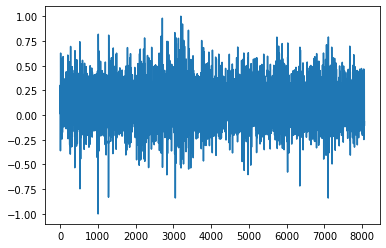

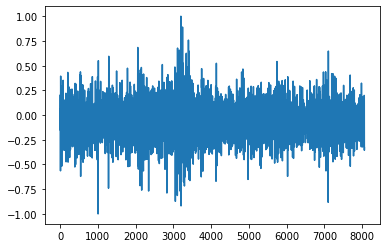

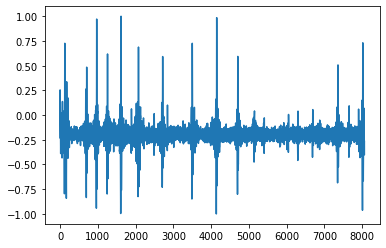

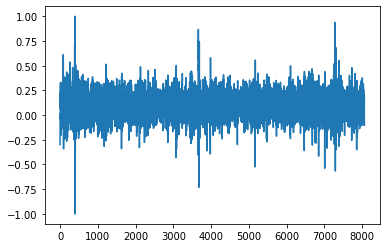

In [18]:
import matplotlib.pyplot as plt
plt.plot(data[0][0, 0, :])
plt.show()
plt.plot(data[0][0, 2, :])
plt.show()
plt.plot(data[1][0, 0, :])
plt.show()
plt.plot(data[2][0, 0, :])
plt.show()

Отлаживаюсь на эмоции с индексом 0 (valence)

In [19]:
type_emotion = 0

Бинаризуем метки и разбиваем видео для каждого человека в соответствии с метками этого человека - оно не всегда будет сбалансированным, как оказалось, но хотя бы метки буду представлены наиболее равномерно. Выведем количестов меток 1 для каждого человека в разбиении

In [20]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import f1_score, accuracy_score
k  = 5
labels_bin = []
for sub in range(32):
  temp = labels[sub] >= 4.5
  #print(labels[i])
  #print(temp)
  labels_bin.append(temp)
  print(sum(labels_bin[sub][:, type_emotion]), end=' ')




20 29 30 17 28 33 30 26 23 24 27 23 20 20 22 17 26 30 26 28 25 22 32 19 24 27 33 25 23 28 29 22 

In [21]:
# indexes = np.arange(NVIDEOS * NSUBJECTS * LEN_RECORD_IN_SECONDS)
# n = len(indexes)
# random.shuffle(indexes)
# inds_train = indexes[0 : int(n * 0.8)]
# inds_test = indexes[int(n * 0.8) :]

# train_dataset = EmotionDataset(data, labels_bin, transforms, inds_train)
# train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
#                                 pin_memory=True, shuffle=True, drop_last=True)



# val_dataset = EmotionDataset(data, labels_bin, transforms,  inds_test)
# val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
#                               pin_memory=True, shuffle=False, drop_last=False)

In [22]:
# sample = val_dataset.__getitem__(300)
# print(sample['data'].shape)
# print(sample['data'][:, :, 0])
# print(sample['labels'])

распределение положительных меток в датасете по каждой эмоции

In [23]:
# print(train_dataset.cnt)
# print(val_dataset.cnt)


In [24]:
def train(model, loader, criterion, optimizer, device, val_dataloader, val_f1_min,  description, type_emotion, batch = None, writer = None):
    model.train()
    train_loss = []
    inputs = []
    torch.autograd.set_detect_anomaly(True)
   
    #lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)#, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
    for i , batch in enumerate(loader):#, total=len(loader), desc="training...", position=0 , leave = True)):
            model.train()
            optimizer.zero_grad()
            src  = batch['data'].to(device)
            #print(src.shape)
            trg = batch['labels'][:, type_emotion]
            #print(batch)
            #print(trg.shape)
            levels_pred = model(src)  # B x (2 * NUM_PTS)
            #print(levels_pred.shape)
            levels_pred = levels_pred.cpu()
            loss = criterion(levels_pred, trg) 

            # loss = 0
            # #loss_all = []
            
            # for class_value in range(2):
            #       mask = (trg == class_value) 
            #       levels_pred_sub = levels_pred[mask]
            #       trg_sub = trg[mask]
            #       #len += trg.shape[0]
            #       #print(f"{trg.shape[0]}", end = " ")
            #       if (trg_sub.shape[0] != 0):
            #             #loss_all.append(criterion(levels_pred_sub, trg_sub)/trg_sub.shape[0])
            #             loss += criterion(levels_pred_sub, trg_sub)/trg_sub.shape[0] 
            # #loss = loss_all[0] + loss_all[1] + (loss_all[0] - loss_all[1]) ** 2
            train_loss.append(loss.item())
            #print(train_loss[-1])
            loss.backward()
            #print(train_loss[-1])
            optimizer.step()
            if writer:
                writer.add_scalar(f'{description}/training loss per batch',
                                  loss.item(),
                                  i)

            # if (i % 100 == 0):
            #     acc, f1 = (calculate_predictions(model, val_dataloader))
            #     if (f1 > val_f1_min):
            #           val_f1_min      = f1
            #           torch.save({'model_state_dict': model.state_dict(),    'optimizer_state_dict': optimizer.state_dict(),}, os.path.join(args.output_dir, f"val.tgz"))
            #break
    return np.mean(train_loss), val_f1_min


In [25]:
def evaluate(model, loader, criterion, device, writer, description, type_emotion):
    
    model.eval()
    epoch_loss = 0
    history = []
  
    with torch.no_grad():
    
        for s, batch in enumerate(loader):#, total=len(loader), desc="validating...", position=0 , leave = True)):
            src  = batch['data'].to(device)
            #print(src.shape)
            trg = batch['labels'][:, type_emotion]



            levels_pred = model(src)  # B x (2 * NUM_PTS)
            #print(levels_pred.shape)
            levels_pred = levels_pred.cpu()
            loss = criterion(levels_pred, trg) 
            epoch_loss += loss.item() 


            if writer:
                writer.add_scalar(f'{description}/val loss per batch',
                                  loss.item(),
                                  s)
        
    return epoch_loss / s

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

def calculate_predictions(model, loader, type_emotion):
    model.eval()
    epoch_loss = 0
    history = []
    real = []
    pred = []
    with torch.no_grad():

        for i, batch in enumerate(loader):#, total=len(loader), desc="predicting...", position=0 , leave = True)):
            src  = batch['data'].to(device)
            #print(src.shape)
            trg = batch['labels'][:, type_emotion]
         

            levels_pred = model(src)  # B x (2 * NUM_PTS)
            levels_pred = levels_pred.cpu()
            #print(levels_pred.shape)
            trg_pred = levels_pred.argmax(1)
            
            real.extend(trg)
            pred.extend(trg_pred) 

            
        #print(accuracy_score(real, pred)) 
        #print(confusion_matrix(real, pred))  
        #print(classification_report(real, pred))  
        f1 = ((f1_score(real, pred, 'binary', pos_label = 0))  + (f1_score(real, pred, 'binary', pos_label = 1)))/2
        return (accuracy_score(real, pred)) , f1
        #plt.hist(real)

In [27]:
def train_loop(description, type_emotion, n_epochs = 10):
    #args.epochs = 10
    #criterion =  fnn.mse_loss
    train_loss_min = 10000
    val_f1_min = -10000

    #batch = next(iter(train_dataloader))
    for epoch in range(n_epochs):
          #logger.info(f"Starting epoch {epoch + 1}/{args.epochs}.")
    
          train_loss, val_f1_min  = train(model, train_dataloader, criterion, optimizer ,device, val_dataloader, val_f1_min ,  description , type_emotion, None,  writer)
          #if epoch % 500 == 0:
          if writer:
                writer.add_scalar(f"{description}/training loss per epoch",
                                        train_loss,
                                        epoch)
          #print(train_loss)

          if (train_loss < train_loss_min):
                 train_loss_min      = train_loss
                 torch.save({
                         'model_state_dict': model.state_dict(),
                         'optimizer_state_dict': optimizer.state_dict(),
                       },
                       os.path.join(args.output_dir, "train.tgz")
            )  

          #val_loss = evaluate(model, val_dataloader, criterion, device,  writer, description )
          # #break
          #print(val_loss)
          #if writer:
          #      writer.add_scalar(f"{description}/val loss per epoch",
          #                        val_loss,
          #                        epoch)
          acc, f1 = (calculate_predictions(model, val_dataloader, type_emotion))
          #print(acc, f1)
          if (acc > val_f1_min):
                       val_f1_min      = acc
                       torch.save({'model_state_dict': model.state_dict(),    'optimizer_state_dict': optimizer.state_dict(),}, os.path.join(args.output_dir, f"val_{description}.tgz")) 

In [28]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [29]:
args.batch_size = 100
indexes = np.arange(NVIDEOS * 1 * LEN_RECORD_IN_SECONDS)
n = len(indexes)
random.shuffle(indexes)
inds_train = indexes[0 : int(n * 0.8)]
inds_test = indexes[int(n * 0.8) :]

#transforms_random = RandomAugmentation([add_noise, reset_part_in_freq, reset_part_in_time, None], 0.2)
#transforms = [RandomAugmentation([add_noise(), reset_part_in_freq(0.2), reset_part_in_time(0.2), None], 0.2), to_head_matrix(),ToTensor()]   
transforms = [to_head_matrix(),ToTensor()] 
#transforms = [RandomAugmentation([add_noise(), None], 0.5), to_head_matrix(),ToTensor()]   
#transforms = [RandomAugmentation([reset_part_in_time(0.4), None], 0.1), to_head_matrix(),ToTensor()]   

train_dataset = EmotionDataset(data[0 : 1], labels_bin[0 : 1], transforms, inds_train)
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                                pin_memory=True, shuffle=True, drop_last=True)

val_dataset = EmotionDataset(data[0: 1], labels_bin[ 0 : 1], transforms,  inds_test)
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=False, drop_last=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model(batch_norm = True, reg_extractor = True, ass_extractor = True)
model.apply(initialize_weights)
criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
train_loop('batchnorm_Yes_batch_100_Adam_lr=3e4_second_subject', 0, 50)

In [31]:
description = 'batchnorm_Yes_batch_100_Adam_lr=3e4_second_subject'
model_state  = torch.load(os.path.join(args.output_dir, f"val_{description}.tgz"))
#   #model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
model.load_state_dict(model_state['model_state_dict'])
acc, f1 = calculate_predictions(model, val_dataloader, 0)
print(acc, f1)

1.0 1.0


**ВЫПОЛНЯТЬ ДО ЭТОГО МЕСТА!**

In [ ]:
!pip install torch_intermediate_layer_getter

In [ ]:
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter

def get_egg_embeddings(model, loader, type_emotion):
    model.eval()
    epoch_loss = 0
    history = []
    trgs = []
    
    with torch.no_grad():
          for s, batch in enumerate(loader):#
            src  = batch['data'].to(device)
            #print(src.shape)
            trg = batch['labels'][:, type_emotion]
            #print(trg.)
            trgs.extend(trg.numpy())
            mid_getter = MidGetter(model, return_layers={'fc1':'fc1'}, keep_output=True)
            mid_output, model_output = mid_getter(src)

            if (s == 0):
                embeddings = mid_output['fc1']
            else:
                embeddings = torch.cat((embeddings, mid_output['fc1']), dim = 0)

           
            
            print(mid_output['fc1'].shape)
            #embeddings.extend(mid_output)
            #break
          return(embeddings, trgs)   

In [ ]:

embeddings, trgs = get_egg_embeddings(model, val_dataloader, type_emotion)

torch.Size([100, 20])
torch.Size([100, 20])
torch.Size([100, 20])
torch.Size([100, 20])
torch.Size([80, 20])


In [ ]:
print(embeddings.shape, trgs)

torch.Size([480, 20]) [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,

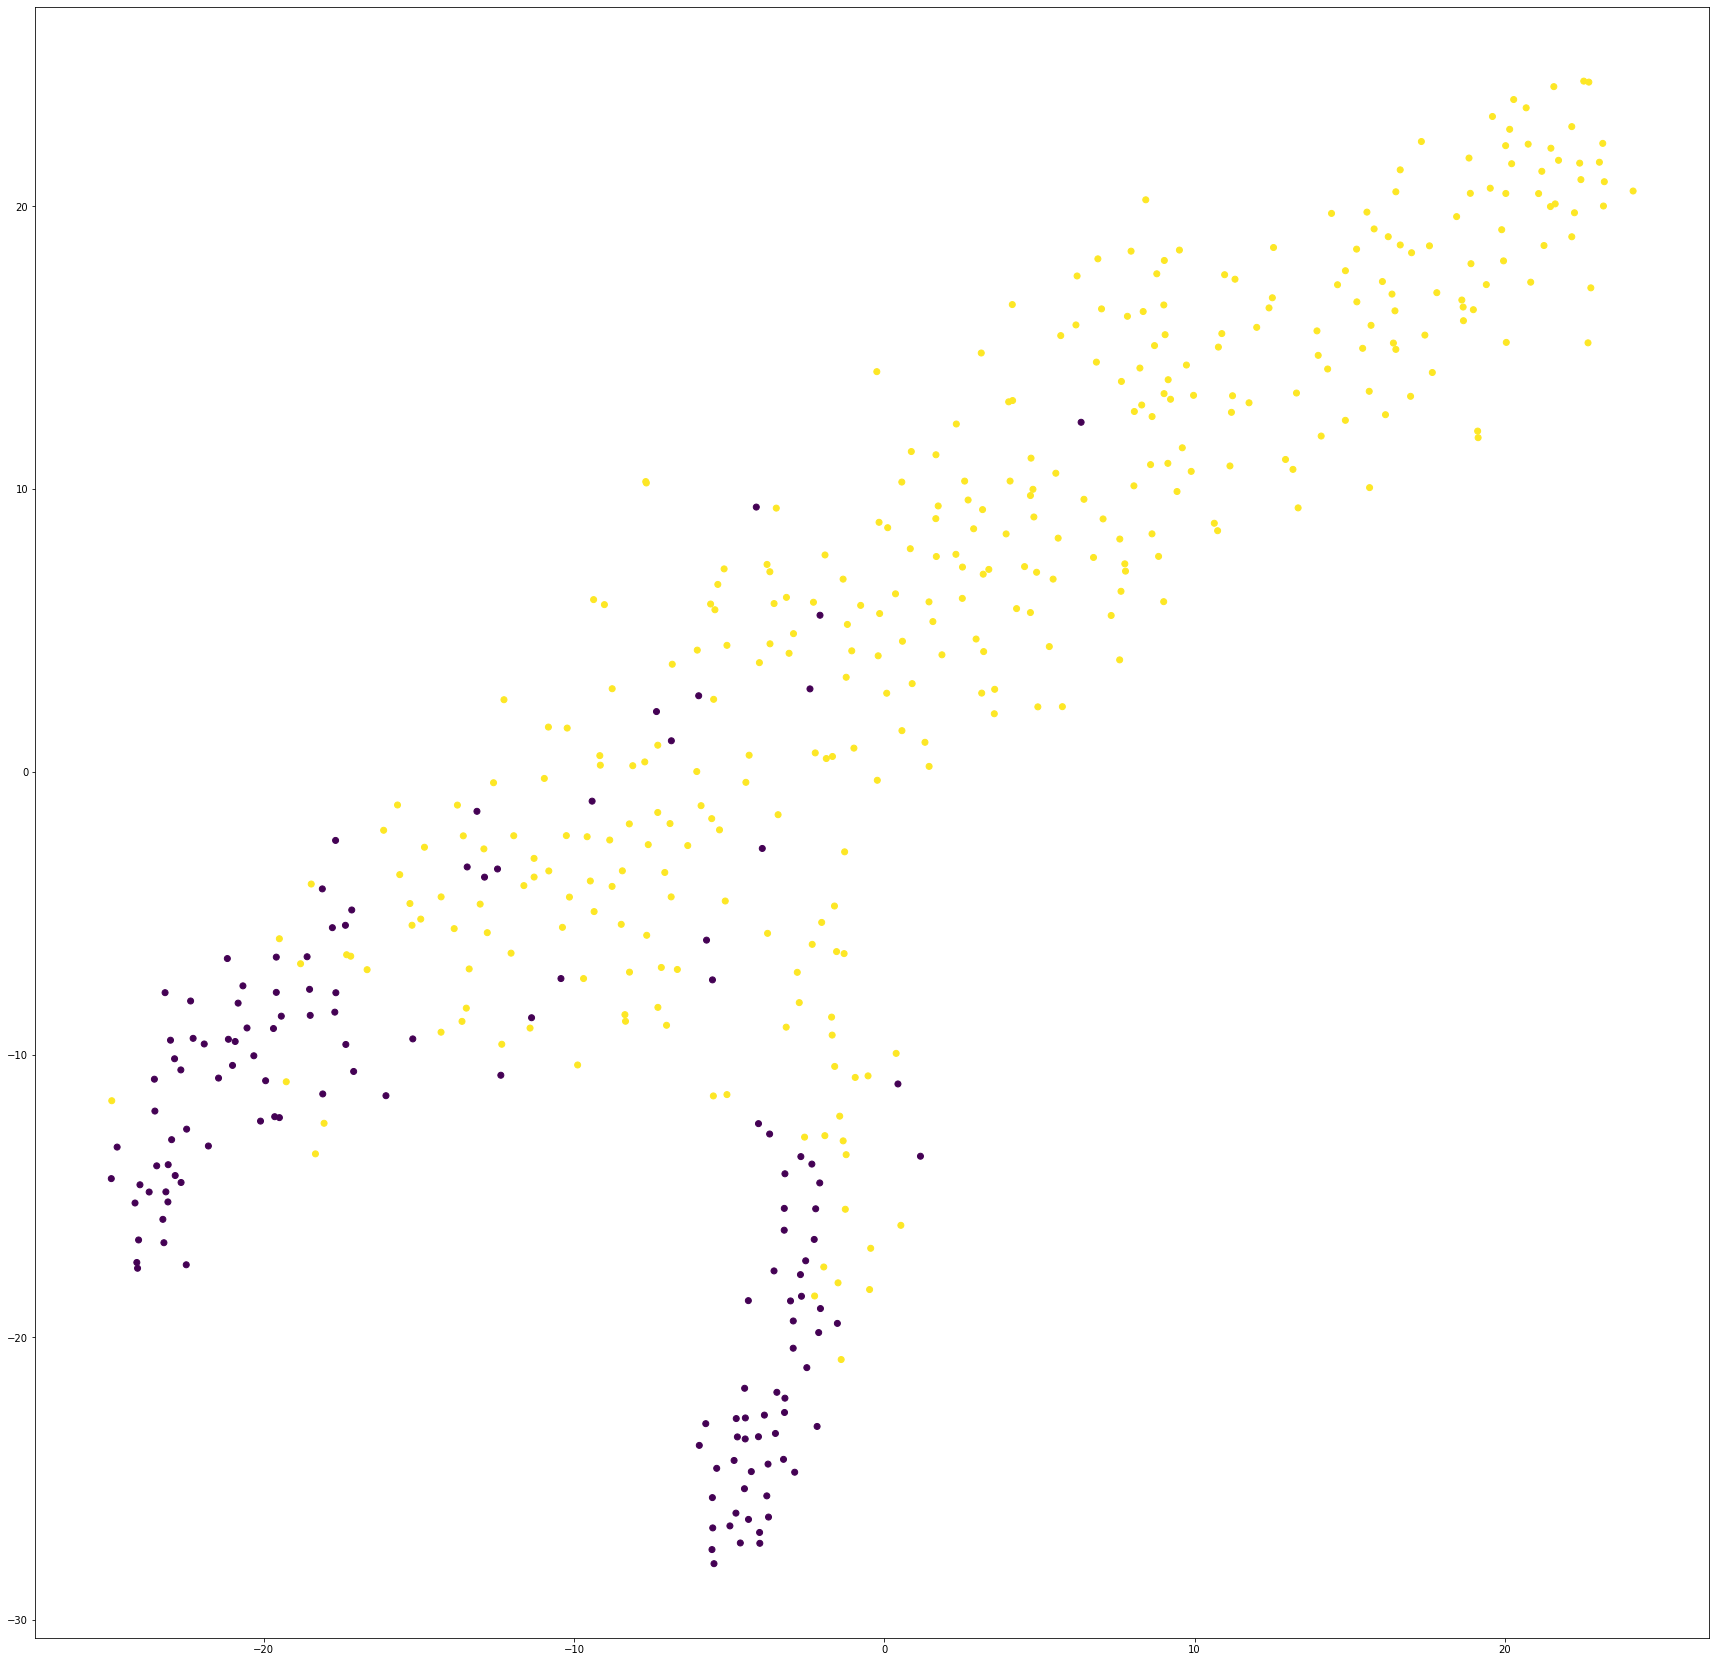

In [ ]:
from sklearn.manifold import TSNE
model_emb = TSNE(learning_rate = 1000)
transformed = model_emb.fit_transform(embeddings.cpu().numpy())
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]


colors = trgs
  #print(colors)
fig, ax = plt.subplots(1, 1, figsize = (30, 30))  
ax.scatter(x_axis, y_axis, c = colors)

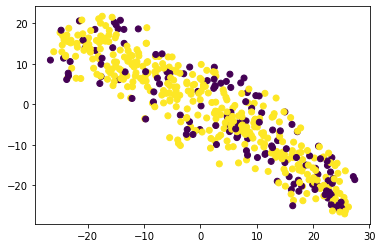

In [ ]:
from sklearn.manifold import TSNE
model_emb = TSNE(learning_rate = 1000)
transformed = model_emb.fit_transform(embeddings.cpu().numpy())
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]


colors = trgs
  #print(colors)
plt.scatter(x_axis, y_axis, c = colors)

In [ ]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import f1_score, accuracy_score


#def get_mertics_per_subject():
k  = 5
type_emotion = 1

acc_all = []
f1_all = []
for sub in range(0,1):
    print(f"*******{sub}*********")

    args.batch_size = 100
    indexes = np.arange(NVIDEOS * 1 * LEN_RECORD_IN_SECONDS)
    n = len(indexes)
    #X = np.arange(40)
    y = []
    for nvideo in range(NVIDEOS):
        y.extend(60 * [labels_bin[sub][nvideo, type_emotion]])
    

    skf = StratifiedKFold(n_splits=k, random_state=None, shuffle=True)
    balanced_split = skf.split(indexes, y)
    acc_sub = []
    f1_sub = []
    for fold,  (inds_train, inds_test) in  enumerate(balanced_split):
        print(f"fold = {fold}")
        #print(inds_train, inds_test)
        #print(sum(labels_bin[sub][inds_train, type_emotion]))
        #print(sum(labels_bin[sub][inds_test, type_emotion]))
        args.batch_size = 100
        #transforms_random = RandomAugmentation([add_noise, reset_part_in_freq, reset_part_in_time, None], 0.2)
        #transforms = [RandomAugmentation([add_noise(), reset_part_in_freq(0.2), reset_part_in_time(0.2), None], 0.2), to_head_matrix(),ToTensor()]   
        transforms = [to_head_matrix(),ToTensor()] 
        #transforms = [RandomAugmentation([add_noise(), None], 0.5), to_head_matrix(),ToTensor()]   
        #transforms = [RandomAugmentation([reset_part_in_time(0.4), None], 0.1), to_head_matrix(),ToTensor()]   

        train_dataset = EmotionDataset(data[sub : sub + 1], labels_bin[sub : sub + 1], transforms, inds_train)
        train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                                    pin_memory=True, shuffle=True, drop_last=True)

        val_dataset = EmotionDataset(data[sub: sub + 1], labels_bin[sub  : sub + 1], transforms,  inds_test)
        val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=False, drop_last=False)
        device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = get_model(batch_norm = True, reg_extractor = True, ass_extractor = True)
        model.apply(initialize_weights)
        criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
        #optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
        optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
        train_loop(f'batchnorm_Yes_batch_100_Adam_lr=3e4_{sub}_{fold}_subject2', 1, 50)
        description = f'batchnorm_Yes_batch_100_Adam_lr=3e4_{sub}_{fold}_subject2'
        model_state  = torch.load(os.path.join(args.output_dir, f"val_{description}.tgz"))
        #   #model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
        model.load_state_dict(model_state['model_state_dict'])
        acc, f1 = calculate_predictions(model, val_dataloader, type_emotion)
        print(f"f1 = {f1} acc = {acc}")
        acc_sub.append(acc)
        f1_sub.append(f1)
        print(acc, f1)
    acc_all.append(acc_sub)     
    f1_all.append(f1_sub)     



    

*******2*********
fold = 0
f1 = 0.9939866202300118 acc = 0.9958333333333333
0.9958333333333333 0.9939866202300118
fold = 1
f1 = 0.9593937698069253 acc = 0.9729166666666667
0.9729166666666667 0.9593937698069253
fold = 2
f1 = 0.9970032776650539 acc = 0.9979166666666667
0.9979166666666667 0.9970032776650539
fold = 3
f1 = 0.9757844818888104 acc = 0.9833333333333333
0.9833333333333333 0.9757844818888104
fold = 4
f1 = 0.984813875056157 acc = 0.9895833333333334
0.9895833333333334 0.984813875056157
*******3*********
fold = 0
f1 = 0.8071245130068658 acc = 0.8083333333333333
0.8083333333333333 0.8071245130068658
fold = 1
f1 = 0.791898922333705 acc = 0.7958333333333333
0.7958333333333333 0.791898922333705
fold = 2
f1 = 0.8162262269392406 acc = 0.8208333333333333
0.8208333333333333 0.8162262269392406
fold = 3
f1 = 0.8324928896721397 acc = 0.8333333333333334
0.8333333333333334 0.8324928896721397
fold = 4
f1 = 0.848842701936703 acc = 0.85
0.85 0.848842701936703
*******4*********
fold = 0
f1 = 0.9933

In [ ]:
import pandas as pd
f1_data_1 = pd.DataFrame(f1_all, columns = ['f1_fold1', 'f1_fold2', 'f1_fold3', 'f1_fold4', 'f1_fold5'])
acc_data_1 = pd.DataFrame(acc_all, columns = ['acc_fold1', 'acc_fold2', 'acc_fold3', 'acc_fold4', 'acc_fold5'])
f1_data_1.to_csv("f1_data_1.cav")
acc_data_1.to_csv("acc_data_1.csv")

2400


In [ ]:
import pandas as pd
f1_data_1 = pd.DataFrame(f1_all, columns = ['f1_fold1', 'f1_fold2', 'f1_fold3', 'f1_fold4', 'f1_fold5'])

In [ ]:
print(f1_data_1)

    f1_fold1  f1_fold2  f1_fold3  f1_fold4  f1_fold5
0   0.972092  0.982390  0.990040  0.987524  0.987524
1   1.000000  1.000000  1.000000  1.000000  1.000000
2   1.000000  1.000000  1.000000  1.000000  1.000000
3   0.997707  1.000000  0.997707  0.997707  0.997707
4   0.937988  0.980877  0.944914  0.985071  0.965899
5   0.997832  0.989121  0.960938  0.976065  0.978299
6   0.920145  0.947768  0.964328  0.958862  0.894387
7   0.991475  0.985090  0.963745  0.985090  0.989337
8   0.991667  0.987500  0.991666  0.947911  0.991667
9   0.987500  0.993750  0.995833  0.993750  0.985416
10  1.000000  0.997895  0.997895  0.997896  0.997895
11  0.987196  0.989337  0.989364  1.000000  0.993602
12  0.995421  1.000000  1.000000  0.997714  1.000000
13  0.975069  0.965896  0.985913  0.991596  0.977264
14  0.908425  0.983996  0.983952  0.993160  0.979191
15  1.000000  0.982534  0.997515  0.982673  0.997525
16  1.000000  0.993326  0.993341  1.000000  0.995556
17  0.884307  0.974788  0.947368  0.921891  0.

In [ ]:
import pandas as pd
acc_data_1 = pd.DataFrame(acc_all, columns = ['acc_fold1', 'acc_fold2', 'acc_fold3', 'acc_fold4', 'acc_fold5'])

In [ ]:
print(acc_data_1)

    acc_fold1  acc_fold2  acc_fold3  acc_fold4  acc_fold5
0    0.977083   0.985417   0.991667   0.989583   0.989583
1    1.000000   1.000000   1.000000   1.000000   1.000000
2    1.000000   1.000000   1.000000   1.000000   1.000000
3    0.997917   1.000000   0.997917   0.997917   0.997917
4    0.939583   0.981250   0.945833   0.985417   0.966667
5    0.997917   0.989583   0.962500   0.977083   0.979167
6    0.931250   0.954167   0.968750   0.964583   0.910417
7    0.991667   0.985417   0.964583   0.985417   0.989583
8    0.991667   0.987500   0.991667   0.947917   0.991667
9    0.987500   0.993750   0.995833   0.993750   0.985417
10   1.000000   0.997917   0.997917   0.997917   0.997917
11   0.987500   0.989583   0.989583   1.000000   0.993750
12   0.995833   1.000000   1.000000   0.997917   1.000000
13   0.981250   0.975000   0.989583   0.993750   0.983333
14   0.916667   0.985417   0.985417   0.993750   0.981250
15   1.000000   0.985417   0.997917   0.985417   0.997917
16   1.000000 

In [ ]:
f1_data_1.to_csv("f1_data_1.cav")
acc_data_1.to_csv("acc_data_1.csv")

In [ ]:
f1_data_0 = pd.read_csv("f1_data.cav")
acc_data_0 = pd.read_csv("acc_data.csv")

In [ ]:
result = pd.concat((acc_data_0, acc_data_1), axis = 0)

In [ ]:
result = result.reset_index()

In [ ]:
result_mean = (result[['acc_fold1',  'acc_fold2' , 'acc_fold3' , 'acc_fold4' , 'acc_fold5']].mean(axis = 1))

In [ ]:
print(result_mean)

0     1.000000
1     0.890417
2     0.997083
3     0.854167
4     0.986667
5     1.000000
6     1.000000
7     0.998333
8     0.963750
9     0.981250
10    0.945833
11    0.983333
12    0.982083
13    0.991250
14    0.998333
15    0.992083
16    0.998750
17    0.984583
18    0.972500
19    0.993333
20    0.996667
21    0.926667
22    0.999167
23    0.919167
24    0.915833
25    0.988333
26    0.994583
27    0.996667
28    0.997083
29    0.998333
30    1.000000
31    0.958333
dtype: float64


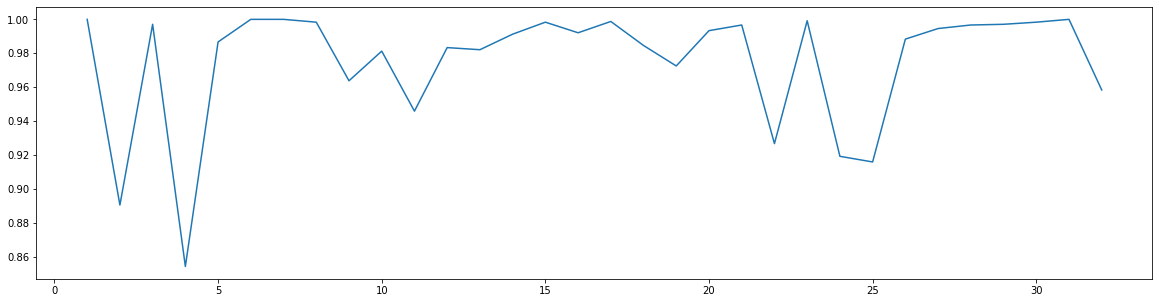

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 5))
ax.plot(np.arange(1,33), result_mean.values)

In [ ]:
c = list(set(inds_train) & set(inds_test))
print(c)

[]


In [ ]:
print(f1_all)
print(acc_all)

[[0.808, 0.8124706985466479, 0.8458092410272438, 0.7874963106998385, 0.8415676464456951, 0.7703509107674107, 0.812340358985943, 0.8278486327612449, 0.7830923248053392, 0.8407710035617013]]
[[0.8083333333333333, 0.8125, 0.8458333333333333, 0.7875, 0.8416666666666667, 0.7708333333333334, 0.8125, 0.8291666666666667, 0.7833333333333333, 0.8416666666666667]]


In [ ]:
import glob
import pickle
from collections import Counter
import scipy
from  scipy import signal
from scipy.fft import fft, fftfreq

class EmotionDataset_balanced(Dataset):
    def __init__ (self, indexes, data, labels_bin):  #indexes - индексы видео которые вошли в датасет, data - данные labels - метки бинарные
       self.data = []
       self.labels = []
       self.cnt = [Counter(), Counter(), Counter(),Counter()]
       self.indexes = indexes
       self.len_files = []
       for sub in range(len(data)): #sub   - человек
            self.data.append(data[sub][indexes[sub], :, 3 * NTIMES_IN_SEC :  LEN_RECORD_IN_SECONDS * NTIMES_IN_SEC + 3 * NTIMES_IN_SEC])
            self.len_files.append(len(indexes[sub]) *  LEN_RECORD_IN_SECONDS - 1) #столько записей будет храниться для каждого человека - количство видео для человека на 60 сек
            self.len_record = LEN_RECORD_IN_SECONDS
            labels_bin_sub = (labels_bin[sub])
            self.labels.append(labels_bin_sub[indexes[sub]])          
            # счетчик числа 1 и 0 в датасете
            for type_emotion in range(4):
              self.cnt[type_emotion].update(list(self.labels[-1][:, type_emotion]))    

            
       self.len_cumsum = np.cumsum(self.len_files)     


    # общее число сеймплов по 1 сек в датасете. их будет 32 * количество видео в датасете * 60 
    def __len__(self):
        result =  sum(self.len_files) - 10
        return result


    # по номеру сеймпла вытягиваем номер человека номер видео и номер секунды
    def get_index_record(self, item):
      for sub in range(len(self.len_cumsum)):
         #print(item, self.len_cumsum[i_file])
         if (item > self.len_cumsum[sub]):
            continue
         else:
            break
      if sub == 0:
         index_in_file = item
      else:
         index_in_file = item  - self.len_cumsum[sub - 1]
      nvideo = index_in_file//(self.len_record)# * LEN_RECORD_IN_SECONDS *  NTIMES_IN_SEC)
      nsec = (index_in_file - nvideo * self.len_record) # *   NTIMES_IN_SEC)

      return sub, nvideo, nsec

   
    def __getitem__(self, item):
      sample = {}
      #print(item)
      sub, nvideo, nsec = self.get_index_record(item)
      #print(i_file, index_in_file, nvideo, nsec )
      sample['data'] = np.zeros((HCANALS, WCANALS, NTIMES_IN_SAMPLE))
      sample_from_one_canals = []
      for i_canal in range(NCANALS):
        sample_from_one_canal1 = self.data[sub][nvideo, i_canal, nsec * 128 : nsec * 128 + 128]
        power = fft(sample_from_one_canal1)
        #sample_from_one_canals.append(sample_from_one_canal)
        sample_from_one_canals.append([0] * 128)
        #print(sample_from_one_canal.shape)
      sample_from_one_canals = np.asarray(sample_from_one_canals).copy()
      # здесь делаем нормализацию фактически по поверхности головы (по одному времени t для всех каналов)
      #sample_from_one_canals = scipy.stats.zscore(sample_from_one_canals, axis = 0)
      for i_canal in range(NCANALS):
          sample['data'][electrode_matrix[list_electrodes[i_canal]][0],  electrode_matrix[list_electrodes[i_canal]][1]] = sample_from_one_canals[i_canal]
      sample['data'] = torch.FloatTensor(sample['data'])
      sample['labels']  = torch.LongTensor(self.labels[sub][nvideo])
      sample['position'] = torch.LongTensor((sub, nvideo, nsec))
      
      return sample

In [ ]:
inds_train = []
inds_test = []
for sub in range(32):  
    X = np.arange(40)
    y = np.array(labels_bin[sub][:, type_emotion])
    skf = StratifiedKFold(n_splits=k, random_state=None, shuffle=True)
    balanced_split = skf.split(X, y)
    for ind_train, ind_test in  balanced_split:
        print(ind_train, ind_test)
        #количестов меток 1 в трейне и тесте
        print(sum(labels_bin[sub][ind_train, type_emotion]), sum(labels_bin[sub][ind_test, type_emotion]))
        print((labels_bin[sub][ind_train, type_emotion]), (labels_bin[sub][ind_test, type_emotion]))
        inds_train.append(ind_train)
        inds_test.append(ind_test)

In [ ]:
train_dataset = EmotionDataset_balanced(inds_train[0:1], data[0:1], labels_bin[0:1])
#class_weights_all = [1/train_dataset.cnt[0][i] for i in range(2)]
#weights_samples =  [0] * train_dataset.__len__()

#A = np.zeros((32, 40, 60))

# for i in range(train_dataset.__len__()):
#     sub, nvideo, nsec = train_dataset.get_index_record(i)
#     #A[sub, nvideo, nsec] = 1
#     #print(train_dataset.labels[i_file][nvideo])
#     weights_samples[i] = class_weights_all[int(train_dataset.labels[sub][nvideo, type_emotion])]

# weighted_sampler = WeightedRandomSampler(
#     weights=weights_samples,
#     num_samples=len(weights_samples),
#     replacement=True
# )
# train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
#                               pin_memory=True, shuffle=False, drop_last=True, sampler=weighted_sampler)

train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                                pin_memory=True, shuffle=True, drop_last=True)

val_dataset = EmotionDataset_balanced(inds_test[0:1], data[0:1], labels_bin[0:1])
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=False, drop_last=False)

In [ ]:
print(train_dataset.__len__())

1909


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model(batch_norm = False, reg_extractor = True, ass_extractor = False)
model.apply(initialize_weights)
criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
train_loop('batchnorm_Yes_batch_100_Adam_lr=3e4_first_subject_proper', 50)

NameError: ignored

In [ ]:
args.batch_size = 1000
train_dataset = EmotionDataset_balanced(inds_train, data, labels_bin)
#class_weights_all = [1/train_dataset.cnt[0][i] for i in range(2)]
#weights_samples =  [0] * train_dataset.__len__()

#A = np.zeros((32, 40, 60))

# for i in range(train_dataset.__len__()):
#     sub, nvideo, nsec = train_dataset.get_index_record(i)
#     #A[sub, nvideo, nsec] = 1
#     #print(train_dataset.labels[i_file][nvideo])
#     weights_samples[i] = class_weights_all[int(train_dataset.labels[sub][nvideo, type_emotion])]

# weighted_sampler = WeightedRandomSampler(
#     weights=weights_samples,
#     num_samples=len(weights_samples),
#     replacement=True
# )
# train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
#                               pin_memory=True, shuffle=False, drop_last=True, sampler=weighted_sampler)

train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                                pin_memory=True, shuffle=True, drop_last=True)

val_dataset = EmotionDataset_balanced(inds_test, data, labels_bin)
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=False, drop_last=False)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model(batch_norm = False, reg_extractor = False, ass_extractor = False)
model.apply(initialize_weights)
criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
train_loop('batchnorm_Yes_batch_100_Adam_lr=3e4_proper', 50)

training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.666019006830747


predicting...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6600731165948557
[[    0  5207]
 [    0 10111]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5207
           1       0.66      1.00      0.80     10111

    accuracy                           0.66     15318
   macro avg       0.33      0.50      0.40     15318
weighted avg       0.44      0.66      0.52     15318



training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6644042104971214


predicting...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6600731165948557
[[    0  5207]
 [    0 10111]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5207
           1       0.66      1.00      0.80     10111

    accuracy                           0.66     15318
   macro avg       0.33      0.50      0.40     15318
weighted avg       0.44      0.66      0.52     15318



training...:   0%|          | 0/61 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

#**ONE MODEL FOR MANY SUBjECTS**

**One NN for all subjects;  args.batch_size = 100 ; optimizer = optim.Adam lr = 3e-4; Compare with BN and without BN**


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model(batch_norm = True, reg_extractor = True, ass_extractor = True)


model.apply(initialize_weights)
criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
args.batch_size = 100
train_loop('batchnorm_YesNo_batch_100_Adam_lr=3e4', 20)

training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.7016456762298209


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7043248414993286


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6622339467533299


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6917059222857157


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6565268958201174


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6917376557985941


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6524974205454842


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6883402347564698


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6483676804870856


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6882374842961629


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6441133725838583


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6864354689915975


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6399325278938793


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6833999276161193


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6362736791860862


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6836397051811218


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6328127218074486


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6816742261250813


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6292194049866473


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6854987382888794


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6251128921743299


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6810751954714457


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6213686261020723


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6826282223065694


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6165102202384198


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6868773778279622


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6123786392759104


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6856162746747335


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.60917222792985


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6849772254625957


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.601642861718037


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.689222498734792


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5988841428131354


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6914530793825785


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5909868136781161


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6927003502845764


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5859017215791296


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6921059687932333


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5804846316087441


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7014727751413982


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model(batch_norm = False, reg_extractor = True, ass_extractor = True)


model.apply(initialize_weights)
criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
args.batch_size = 100
train_loop('batchnorm_YesNo_batch_100_Adam_lr=3e4', 20)

training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6840562683637025


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6983989596366882


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6635665874012181


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.697729742527008


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.659883409249978


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6974235097567241


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6558669873925506


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6980860551198323


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6538670405012662


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6956311941146851


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6521895088133265


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6976600567499797


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6496237252579361


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7065297444661458


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.650059744959972


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6998415152231853


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.645946304329106


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7016630291938781


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6431997770168743


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.700908613204956


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6415180534612938


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7133993943532307


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6378912349216274


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7016950408617656


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6367720424151811


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7134480675061544


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.634019356282031


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.70606396595637


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6313472790796248


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7018320679664611


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6292027264344887


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7023128509521485


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.626567141931565


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7036839842796325


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6243797667690965


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7122471253077189


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6222571623129923


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7146392265955607


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6189766790046066


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7200896700223287


**One NN for all subjects;  args.batch_size = 1000 ; optimizer = optim.SGD lr = 3e-5; BN+**


In [ ]:
args.batch_size = 1000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#train_dataset = EmotionDataset(data, labels_bin, transforms, inds_train)
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                                pin_memory=True, shuffle=True, drop_last=True)

#val_dataset = EmotionDataset(data, labels_bin, transforms,  inds_test)
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=False, drop_last=False)

model =  get_model(batch_norm = True, reg_extractor = True, ass_extractor = True)
model.apply(initialize_weights)
criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
train_loop('batchnorm_Yes_batch_1000_Adam_lr=3e4', 30)

training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6842492320498482


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6989391644795736


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6586716155536839


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6925116499265035


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.652974253795186


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6916309277216593


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6501430204657258


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6915264924367269


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6467831222737421


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6885719497998556


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6429207852629365


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6872917970021566


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6380484612261663


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.684728495279948


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6343883315070731


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6838552474975585


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6309790445155785


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6844698707262675


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6260523024152537


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6831246217091879


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6197592762650036


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.689423664410909


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6161376433294328


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.68888734181722


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.609004084204064


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6848950862884522


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6024217439479516


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6856662511825562


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5983209678384124


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6956638058026632


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5900674169180823


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6956552743911744


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5844195788023901


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6983383695284525


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5754532325463216


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7037651777267456


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5688300455202822


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.707752239704132


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.562589599460852


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.706528381506602


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5555246560299982


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7164254903793335


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5485347968633058


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.715425976117452


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5410857825982766


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7252824187278748


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5325076296681264


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7391227046648662


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5265919018964298


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7502178271611532


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5209621557446776


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7710259437561036


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5140219643467763


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7466405789057414


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.505898624170022


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7881953835487365


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5001971623936637


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7869554956754049


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.49445813747703055


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7821211377779643


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model(batch_norm = True, reg_extractor = True, ass_extractor = True)


model.apply(initialize_weights)
criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
#optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
args.batch_size = 100
train_loop('batchnorm_YesNo_batch_1000_SGD_lr=3e4', 20)

training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.7705943848265976


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7347327033678691


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.7338711638919643


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7401577909787496


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.7178129319284783


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7311607758204143


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.710066882313275


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7276242772738138


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.7009300980411592


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7237907489140828


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6964757032081729


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7204461812973022


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6920847071975958


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7182197213172913


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6868955532058341


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7163090825080871


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6861271389195176


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.714877990881602


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6836930269100627


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.713611098130544


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6815619800911575


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7125734925270081


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6792625599220151


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7112695535024007


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6769323397855289


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.71020933787028


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6760957094489551


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7094055016835531


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6747258510745939


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7086309274037679


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6737646470304395


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7077083786328634


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6724084332341054


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7070480068524678


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6720048931778454


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7065287391344707


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6714566760375852


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7064116597175598


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6708018388904509


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7055461963017782


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model(batch_norm = False, reg_extractor = True, ass_extractor = True)


model.apply(initialize_weights)
criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=3e-4, momentum = 0.9)#, weight_decay=args.weight_decay)
#optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
args.batch_size = 100
train_loop('batchnorm_YesNo_batch_1000_SGD_lr=3e4', 20)

training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.7229139677813796


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7229195396105449


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.691590564172776


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7174437642097473


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6768326006951879


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7098787824312845


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6712338699669135


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.706379234790802


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.668264699763939


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7042230844497681


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6659941155402387


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7031669696172078


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6655116051924034


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.702689524491628


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6639721784435335


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.701989742120107


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6631934222627859


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7014514525731405


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6624651766214215


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7011852979660034


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6626327653400234


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.701130751768748


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6611857326304327


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7005005637804668


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6606424294534277


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7002468983332316


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6604740717371956


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7000252525011699


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6596697871802283


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7000211318333943


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6589562296867371


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6998047590255737


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6584975582654359


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6994768102963765


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6583955444273402


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6996647874514262


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6575109225804688


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6990923086802164


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6571788269965375


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6989370226860047


**One NN for all subjects;  args.batch_size = 1000 ; optimizer = optim.Adam lr = 3e-4; BN+; Without Assymetric Extractor**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model(batch_norm = True, reg_extractor = True, ass_extractor = False)
model.apply(initialize_weights)
criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
args.batch_size = 1000
train_loop('batchnorm_YesNo_batch_1000_Adam_lr=3e4_assext_No', 20)


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6688391976669187


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6986334244410197


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6570096211355241


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6930981040000915


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6533469684788438


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6923754930496215


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6492707954078424


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6882504185040792


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6457859062757648


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6888752222061157


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.642966332982798


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6875845750172933


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6388498544692993


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6865849733352661


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6339067767878048


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6894890546798706


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6293460961248054


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6865662336349487


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6228480827612956


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6871647000312805


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.616668209677837


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6884449243545532


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6108183460157426


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6939959446589152


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6040395703472075


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6914250532786052


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5964951915819137


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.693399453163147


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5885742736644433


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.6990398645401001


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5809903936307939


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7015604694684346


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5717232686574342


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7101009448369344


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5636868125102559


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7200897773106892


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5549871911768054


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7283748547236125


training...:   0%|          | 0/61 [00:00<?, ?it/s]

0.5488446286467256


validating...:   0%|          | 0/16 [00:00<?, ?it/s]

0.7301583846410116


**One NN for all subjects; args.batch_size = 1000 ; optimizer = optim.Adam lr = 3e-4; BN+; Without Regional Extractor**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model(batch_norm = True, reg_extractor = False, ass_extractor = True)
model.apply(initialize_weights)
criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
args.batch_size = 1000
train_loop('batchnorm_YesNo_batch_1000_Adam_lr=3e4_regext_No', 20)

**One NN for all subjects; args.batch_size = 1000 ; optimizer = optim.Adam lr = 3e-4; BN+; Without Regional Extractor Without Assymetric Extractor**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model(batch_norm = True, reg_extractor = False, ass_extractor = False)
model.apply(initialize_weights)
criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
args.batch_size = 1000
train_loop('batchnorm_YesNo_batch_1000_Adam_lr=3e4_regext_No_assext_No', 20)

#**ONE MODEL FOR ONE SUBJECT**

In [ ]:
args.batch_size = 100
indexes = np.arange(NVIDEOS * 1 * LEN_RECORD_IN_SECONDS)
n = len(indexes)
random.shuffle(indexes)
inds_train = indexes[0 : int(n * 0.8)]
inds_test = indexes[int(n * 0.8) :]

train_dataset = EmotionDataset(data[0 : 1], labels_bin[0 : 1], transforms, inds_train)
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                                pin_memory=True, shuffle=True, drop_last=True)

val_dataset = EmotionDataset(data[0: 1], labels_bin[ 0 : 1], transforms,  inds_test)
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=False, drop_last=False)

In [ ]:
print(train_dataset.cnt)
print(val_dataset.cnt)

In [ ]:
model =  get_model(batch_norm = True, reg_extractor = True, ass_extractor = True)
model.apply(initialize_weights)
criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
args.batch_size = 100
train_loop('batchnorm_Yes_batch_100_lr=3e4_first_subject', 20)

In [ ]:
model =  get_model(batch_norm = False, reg_extractor = True, ass_extractor = True)
model.apply(initialize_weights)
criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
args.batch_size = 100
train_loop('batchnorm_No_batch_100_lr=3e4_first_subject', 20)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model(batch_norm = True, reg_extractor = False, ass_extractor = False)
model.apply(initialize_weights)
criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
args.batch_size = 1000
train_loop('batchnorm_Yes_batch_1000_Adam_lr=3e4_regext_No_assext_No_first_subject', 20)

In [ ]:
# On Colab just uncomment and run this cell
#!kill 484
%load_ext tensorboard
%tensorboard --logdir runs


In [ ]:
acc, f1 = calculate_predictions(model, val_dataloader)
print(acc, f1)

А теперь смотрим как отрабатывает классификатор на всех людях по раздельности

In [ ]:
args.batch_size = 1000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#train_dataset = EmotionDataset(data, labels_bin, transforms, inds_train)
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                                pin_memory=True, shuffle=True, drop_last=True)

#val_dataset = EmotionDataset(data, labels_bin, transforms,  inds_test)
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=False, drop_last=False)

model =  get_model(batch_norm = True, reg_extractor = True, ass_extractor = True)
model.apply(initialize_weights)
criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
train_loop('batchnorm_Yes_batch_1000_Adam_lr=3e4', 30)

In [ ]:
model_state  = torch.load(os.path.join(args.output_dir, f"val.tgz"))
  #model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
model.load_state_dict(model_state['model_state_dict'])

In [ ]:
acc, f1 = calculate_predictions(model, val_dataloader)
print(acc, f1)

In [ ]:
accs_all = []
f1_all = []
for sub in range(32):
  #for fold in range(len(ind_tests)):
  #model_state  = torch.load(os.path.join(args.output_dir, f"val.tgz"))
  #model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
  #model.load_state_dict(model_state['model_state_dict'])
  val_dataset_sub = EmotionDataset(inds_test, data[sub:sub + 1], labels_bin[sub : sub + 1])
  val_dataloader_sub = DataLoader(val_dataset_sub, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=False, drop_last=False)
    
  #print(val_datar_sub.cnt)
  acc, f1 = calculate_predictions(model, val_dataloader_sub)
  print(acc, f1)
  accs_all.append(acc)
  f1_all.append(f1)
  # print(np.mean(accs_all))    
  # print(np.mean(f1_all))    
  # accs_result.append(np.mean(accs_all))
  # f1_result.append(np.mean(f1_all))


In [ ]:
print(np.mean(accs_all))    
print(np.mean(f1_all))   